In [ ]:
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
#Make a binary classification dataset with Scikit-Learn's make_moons() function.
#For consistency, the dataset should have 1000 samples and a random_state=42.
#Turn the data into PyTorch tensors. Split the data into training and test sets using train_test_split with 80% training and 20% testing.

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import torch
import matplotlib.pyplot as plt


# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_moons(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values


# Turn data into tensors
# Otherwise this causes issues with computations later on
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [ ]:
# Make DataFrame of circle data
import pandas as pd
moons = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
moons.head(10)

,X1,X2,label
0,-0.009332,0.390981,1.0
1,0.954574,-0.473756,1.0
2,0.918526,-0.425196,1.0
3,0.412768,-0.376385,1.0
4,-0.845320,0.528799,0.0
5,0.579542,-0.352979,1.0
6,0.294884,-0.209238,1.0
7,-0.014488,0.435896,1.0
8,1.626510,-0.281207,1.0
9,0.671598,0.786422,0.0


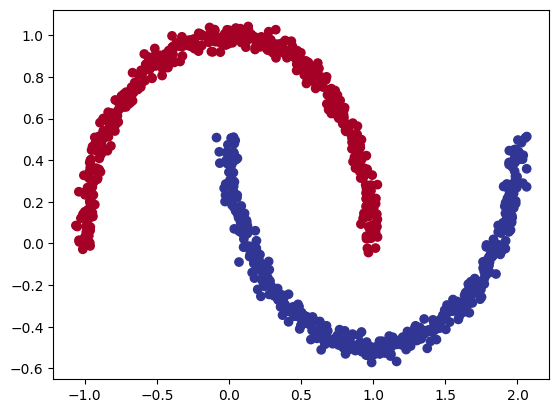

In [ ]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

In [ ]:
# Build a model by subclassing nn.Module that incorporates non-linear activation functions and is capable of fitting the data you created in 1.
# Feel free to use any combination of PyTorch layers (linear and non-linear) you want.


class BinaryClassification(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.leakyrelu = nn.LeakyReLU(0.01)
  def forward(self, x):
    x = self.layer_1(x)
    x = self.leakyrelu(x)
    x = self.layer_2(x)
    x = self.leakyrelu(x)
    x = self.layer_3(x)
    x= self.leakyrelu(x)
    return x



In [ ]:
model_0 = BinaryClassification().to(device)
model_0

BinaryClassification(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (leakyrelu): LeakyReLU(negative_slope=0.01)
)

In [ ]:
# Setup a binary classification compatible loss function and optimizer to use when training the model.

# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
# optimizer = torch.optim.SGD(params=model_0.parameters(),
                            # lr=0.1)

optimizer = torch.optim.Adam(model_0.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9) # Reduce LR by factor of 0.9 every 100 epochs


In [ ]:
# Calculate accuracy (a classification metric)
!pip -q install torchmetrics # colab doesn't come with torchmetrics
from torchmetrics import Accuracy
acc_fn = Accuracy(task="multiclass", num_classes=2).to(device) # send accuracy function to device
acc_fn

MulticlassAccuracy()

In [ ]:
# Create a training and testing loop to fit the model you created in 2 to the data you created in 1.
# To measure model accuracy, you can create your own accuracy function or use the accuracy function in TorchMetrics.
# Train the model for long enough for it to reach over 96% accuracy.
# The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.


torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls

    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train)
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train)
    acc = acc_fn(y_pred,y_train.int())

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()
    scheduler.step()
    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = acc_fn(y_test.int(),
                               test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.71690, Accuracy: 0.50% | Test loss: 0.70987, Test acc: 0.50%
Epoch: 100 | Loss: 0.38247, Accuracy: 0.96% | Test loss: 0.37476, Test acc: 0.95%
Epoch: 200 | Loss: 0.33734, Accuracy: 1.00% | Test loss: 0.33682, Test acc: 1.00%
Epoch: 300 | Loss: 0.31113, Accuracy: 1.00% | Test loss: 0.31100, Test acc: 1.00%
Epoch: 400 | Loss: 0.22757, Accuracy: 1.00% | Test loss: 0.23441, Test acc: 1.00%
Epoch: 500 | Loss: 0.13288, Accuracy: 1.00% | Test loss: 0.14410, Test acc: 1.00%
Epoch: 600 | Loss: 0.07455, Accuracy: 1.00% | Test loss: 0.08576, Test acc: 1.00%
Epoch: 700 | Loss: 0.04392, Accuracy: 1.00% | Test loss: 0.05298, Test acc: 1.00%
Epoch: 800 | Loss: 0.02807, Accuracy: 1.00% | Test loss: 0.03793, Test acc: 0.99%
Epoch: 900 | Loss: 0.02004, Accuracy: 1.00% | Test loss: 0.02873, Test acc: 0.99%


In [ ]:
# Make predictions
model_0.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_0(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

In [27]:
# Make predictions with your trained model and plot them using the plot_decision_boundary() function created in this notebook.

import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary


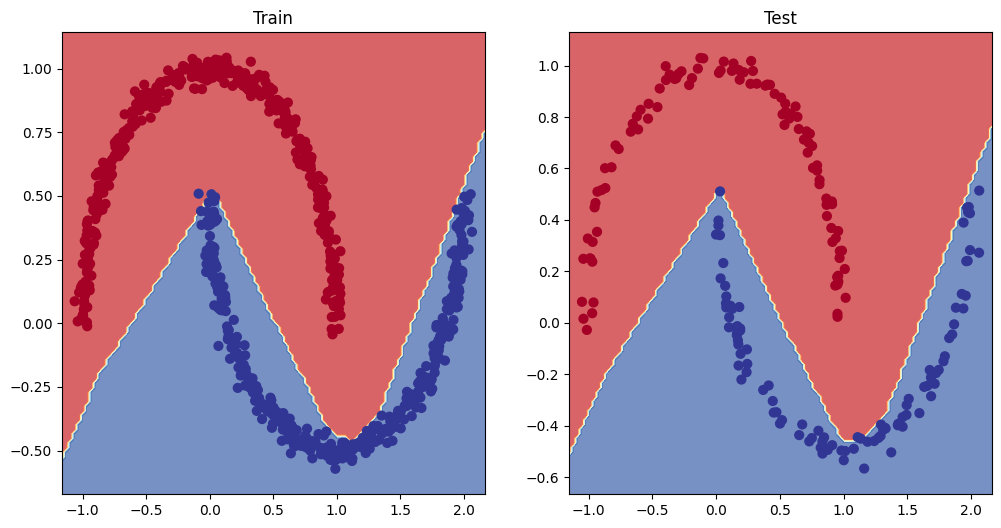

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [ ]:
# Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.
# Feel free to reference the ML cheatsheet website for the formula.

import torch

def tanh_custom(x):
  """
  Replicates the Tanh activation function in pure PyTorch.

  Args:
    x: The input tensor.

  Returns:
    The output tensor after applying the Tanh function.
  """
  return (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))


input_tensor = torch.tensor([1.0, 2.0, 3.0])
output_tensor = tanh_custom(input_tensor)

output_tensor


tensor([0.7616, 0.9640, 0.9951])

In [ ]:
# Create a multi-class dataset using the spirals data creation function from CS231n (see below for the code).
# Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).
# Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).
# Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like).
# Plot the decision boundaries on the spirals dataset from your model predictions, the plot_decision_boundary() function should work for this dataset too.

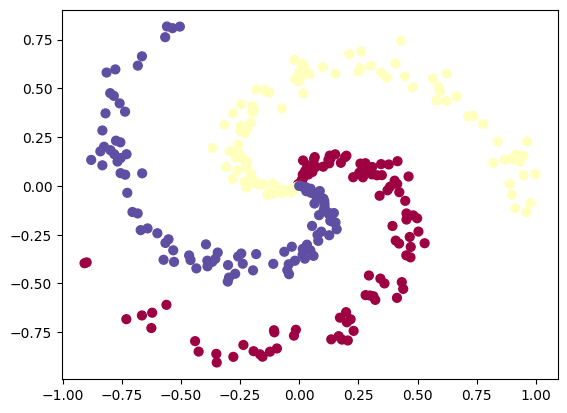

In [1]:
# Code for creating a spiral dataset from CS231n
import matplotlib.pyplot as plt

import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [2]:
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)
print(X[:5], y[:5])

tensor([[ 0.0000,  0.0000],
        [-0.0045,  0.0091],
        [ 0.0098,  0.0177],
        [ 0.0100,  0.0286],
        [ 0.0148,  0.0376]]) tensor([0, 0, 0, 0, 0])


In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
    y,
    test_size=0.2,
    random_state=42
)

In [4]:
len(X_train), len(X_test), len(y_train), len(y_test)

(240, 60, 240, 60)

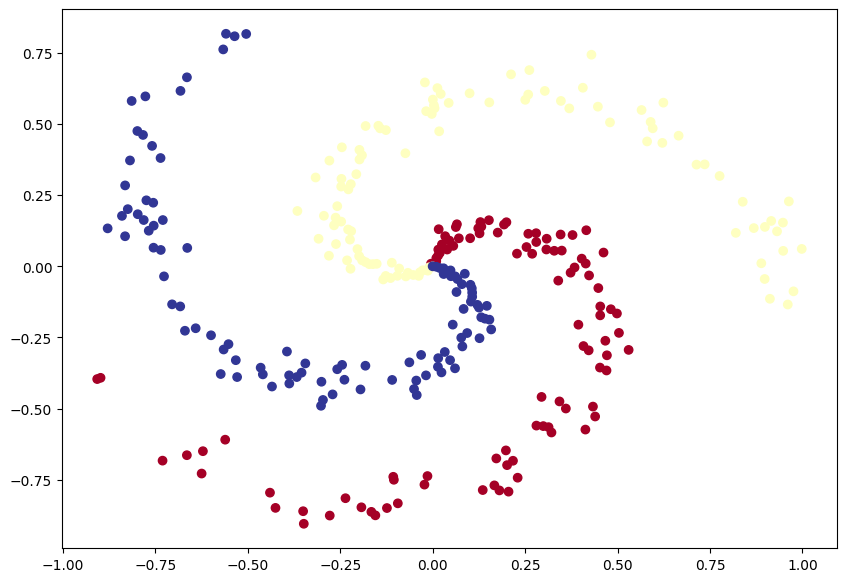

In [5]:
plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [6]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [18]:
from torch import nn

# Build model
class MultiClass(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
            #nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = MultiClass(input_features=D,
                    output_features=K,
                    hidden_units=128).to(device)
model_4

MultiClass(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=3, bias=True)
  )
)

In [20]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(),lr=0.1) # exercise: try changing the learning rate here and seeing what happens to the model's performance

optimizer = torch.optim.Adam(model_4.parameters(), lr=0.01)
# scheduler = torch.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.9)


In [21]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_4(X_train.to(device))[:5]

tensor([[ 0.0455, -0.0309,  0.0529],
        [ 0.0521, -0.0179,  0.0467],
        [ 0.0353, -0.0271,  0.0346],
        [ 0.0447, -0.0041,  0.0151],
        [ 0.0387, -0.0101,  0.0088]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [22]:
# How many elements in a single prediction sample?
model_4(X_train.to(device))[0].shape, K

(torch.Size([3]), 3)

In [23]:
# Make prediction logits with model
y_logits = model_4(X_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 0.0367, -0.0286,  0.0382],
        [ 0.0337, -0.0088,  0.0489],
        [ 0.0344, -0.0174,  0.0112],
        [ 0.0351, -0.0268,  0.0334],
        [ 0.0458, -0.0304,  0.0520]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.3403, 0.3188, 0.3408],
        [0.3363, 0.3223, 0.3414],
        [0.3417, 0.3244, 0.3339],
        [0.3403, 0.3199, 0.3398],
        [0.3410, 0.3159, 0.3431]], device='cuda:0', grad_fn=<SliceBackward0>)


In [24]:
# Calculate accuracy (a classification metric)
!pip -q install torchmetrics # colab doesn't come with torchmetrics
from torchmetrics import Accuracy
acc_fn = Accuracy(task="multiclass", num_classes=3).to(device) # send accuracy function to device
acc_fn

MulticlassAccuracy()

In [25]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_train) # model outputs raw logits
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train)
    acc = acc_fn(y_train,
                      y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()
    # scheduler.step()
    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = acc_fn(y_test,
                             test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.09336, Acc: 0.48% | Test Loss: 1.01347, Test Acc: 0.62%
Epoch: 100 | Loss: 0.02478, Acc: 0.99% | Test Loss: 0.00213, Test Acc: 1.00%
Epoch: 200 | Loss: 0.01814, Acc: 0.99% | Test Loss: 0.00043, Test Acc: 1.00%
Epoch: 300 | Loss: 0.01631, Acc: 0.99% | Test Loss: 0.00048, Test Acc: 1.00%
Epoch: 400 | Loss: 0.01534, Acc: 0.99% | Test Loss: 0.00012, Test Acc: 1.00%
Epoch: 500 | Loss: 0.01476, Acc: 0.99% | Test Loss: 0.00005, Test Acc: 1.00%
Epoch: 600 | Loss: 0.01504, Acc: 0.99% | Test Loss: 0.00002, Test Acc: 1.00%
Epoch: 700 | Loss: 0.01487, Acc: 0.99% | Test Loss: 0.00001, Test Acc: 1.00%
Epoch: 800 | Loss: 0.01456, Acc: 0.99% | Test Loss: 0.00001, Test Acc: 1.00%
Epoch: 900 | Loss: 0.01437, Acc: 0.99% | Test Loss: 0.00001, Test Acc: 1.00%


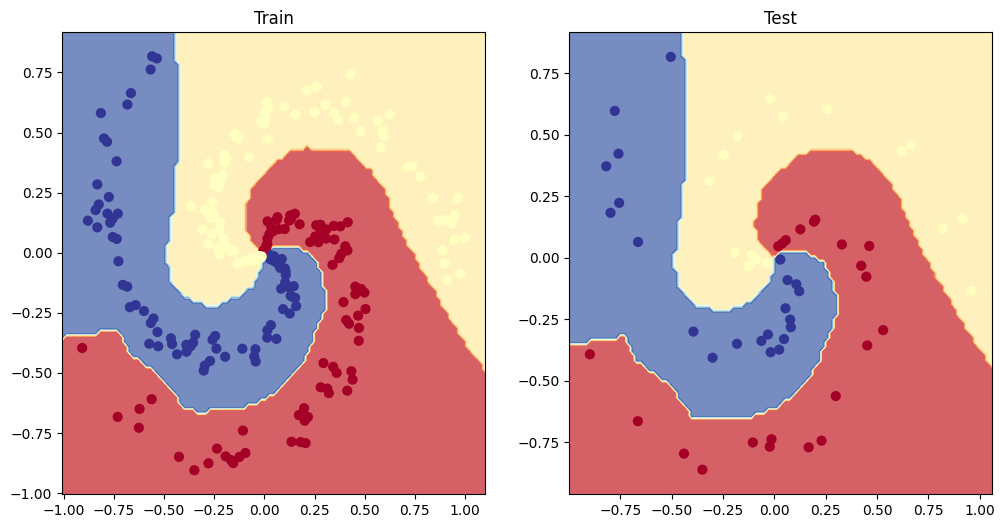

In [28]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_test, y_test)